In [284]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os,sys
from astropy.modeling import models
import astropy.units as u
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from astropy import constants as const
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters
from astropy.modeling import fitting
#fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)
fitter = fitting.LevMarLSQFitter('param_cov')
from scipy.signal import savgol_filter
from extinction import ccm89, apply, remove,Fitzpatrick99
import extinction
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian1D
from astropy.convolution import convolve_models

In [295]:
line_list = { # these are all in air not vacuum
    'H-alpha': 6562.80,
    'H-beta': 4861.333,
    'OIII 4959': 4958.911,
    'OIII_2 5007': 5006.843,
    'NII 6548': 6548.050 ,
    'NII_2 6583': 6583.460,
    'SII 6716': 6716.440,
    'SII_2 6731': 6730.810,
    #
    'N III': 4097.36,
    'N III_2': 4103.39,
    'H I  ': 4340.47,
    'He II': 4541.49,
    'N III': 4634.14,
    'N III_2': 4640.64,
    'C III 4647': 4647.42,
    'C III 4650': 4650.25,
    'He II 4685': 4685.8,
    'He II 4859': 4859.32,
    'He II 5412': 5411.52,
    'C III 5696': 5695.92,
    'C IV 5801': 5801.31,
    'C IV_2 5812': 5811.97,   
    #
    'DIB 5780': 5780, #Diffuse Interstellar Bands - absorption of light by the interstellar medium, PAH and carbon
    'DIB 4428': 4428,
    'DIB 6379': 6379,
    #
    'NA ID 5893': 5892.9, #Sodium doublet combined wavelength
    'NA ID 1': 5889.95, #λλ5889.95, 5895.92
    'NA ID 2': 5895.92, #λλ5889.95, 5895.92
    'CA_II 3969': 3968.5, #“Calcium H and K
    'K 7665': 7664.9, # potassium doublet
    'KI 7699': 7698.96,
    'LI 6706': 6707, #Lithium 
    'CN 3883': 3883.4, #Copernicium
}



In [296]:
# read in spectrum
file='2021sjt-LRIS-2021-07-08.csv'
data = np.genfromtxt(file,names=True,comments='#', delimiter=',')

wav=data['wavelength']
flux=data['flux']
fluxerr=data['fluxerr']

# give spectrum correct units
flux1 = flux * 10**(-15) * u.Unit('erg cm-2 s-1 AA-1')
fluxerr1 = fluxerr * 10**(-15) * u.Unit('erg cm-2 s-1 AA-1')
wav1 = wav * u.AA # wavelength in Angstroms

z=0.00475 # redshift of the SN



In [297]:

# Step 1 - Apply Galactic extinction correction to the spectrum

# E(B-V) =  0.328
# R_V = 3.1$;  changes the shape of the extinction curve, rather than just the amplitude. A_V is linear scaling
# Cardelli, Clayton & Mathis (1989) R_V = 3.1
# R_V=A_V/E(B-V), where E(B-V) is the difference in extinction between the B and V bands 
# A_V = R_V * E(B-V) = 3.1 * 0.328 = 1.0168
# "deredden" flux by 1.0168
# https://extinction.readthedocs.io/en/latest/api/extinction.fitzpatrick99.html
dereddened_flux=remove(extinction.fitzpatrick99(wav1, a_v=1.0168, r_v=3.1), flux1) # correct for milky way extinction


# Step 2 - Correct spectrum wavelength for redshift
wav1=wav1/(1+z)
print(ind[0][0])

2271


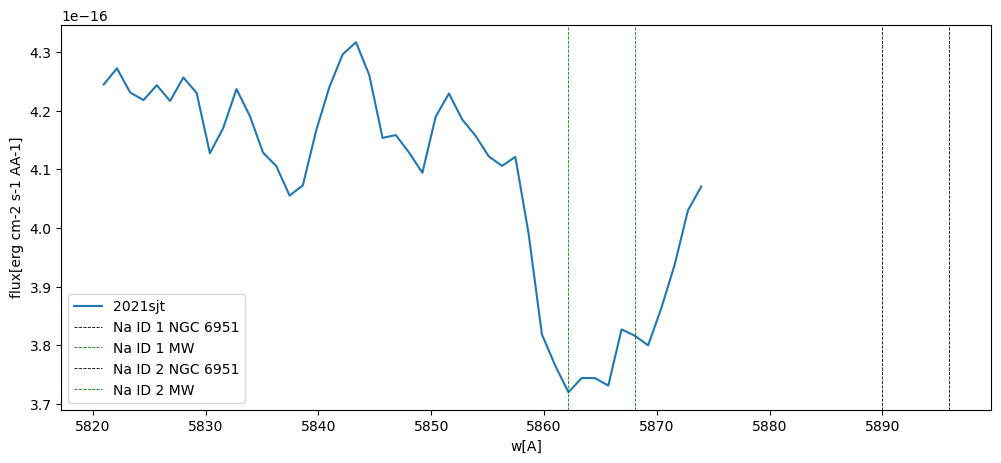

In [316]:
wav_region_left=5820 * u.AA
wav_region_right=5875* u.AA
ind=np.where((wav1>wav_region_left) & (wav1<wav_region_right))
fig, ax = plt.subplots(figsize=(12,5),nrows=1, ncols=1)
ax.plot(wav1[ind], dereddened_flux[ind], label = '2021sjt')

# plot Na ID absorption from 2021sjt, 
ax.axvline(line_list['NA ID 1'], color='black', linestyle='--',linewidth=0.6, label = 'Na ID 1 NGC 6951')
ax.axvline(line_list['NA ID 1']/(1+z), color='green', linestyle='--',linewidth=0.6, label = 'Na ID 1 MW')

ax.axvline(line_list['NA ID 2'], color='black', linestyle='--',linewidth=0.6, label = 'Na ID 2 NGC 6951')
ax.axvline(line_list['NA ID 2']/(1+z), color='green', linestyle='--',linewidth=0.6, label = 'Na ID 2 MW')

plt.legend()
plt.xlabel("w[A]")
ax.set_ylabel("flux[erg cm-2 s-1 AA-1]")
plt.show()



In [317]:
NA_ID_1_NGC=line_list['NA ID 1']
NA_ID_2_NGC=line_list['NA ID 2']
NA_ID_1_MW=line_list['NA ID 1']/(1+z)
NA_ID_2_MW=line_list['NA ID 2']/(1+z)

spectrum = Spectrum1D(flux=dereddened_flux , spectral_axis=wav1)
#print(NA_ID_1_NGC, NA_ID_2_NGC, NA_ID_1_MW, NA_ID_2_MW)
sub_region = SpectralRegion(wav1[ind].min(), wav1[ind].max())
print(sub_region)
sub_spectrum = extract_region(spectrum, sub_region)
print(sub_spectrum)
line_estimates=estimate_line_parameters(sub_spectrum, models.Gaussian1D())

Spectral Region, 1 sub-regions:
  (5820.9624284647925 Angstrom, 5873.942771833789 Angstrom) 

Spectrum1D (length=46)
flux:             [ 4.2447e-16 erg / (Angstrom cm2 s), ..., 4.0708e-16 erg / (Angstrom cm2 s) ],  mean=4.0825e-16 erg / (Angstrom cm2 s)
spectral axis:    [ 5821.0 Angstrom, ..., 5873.9 Angstrom ],  mean=5847.5 Angstrom


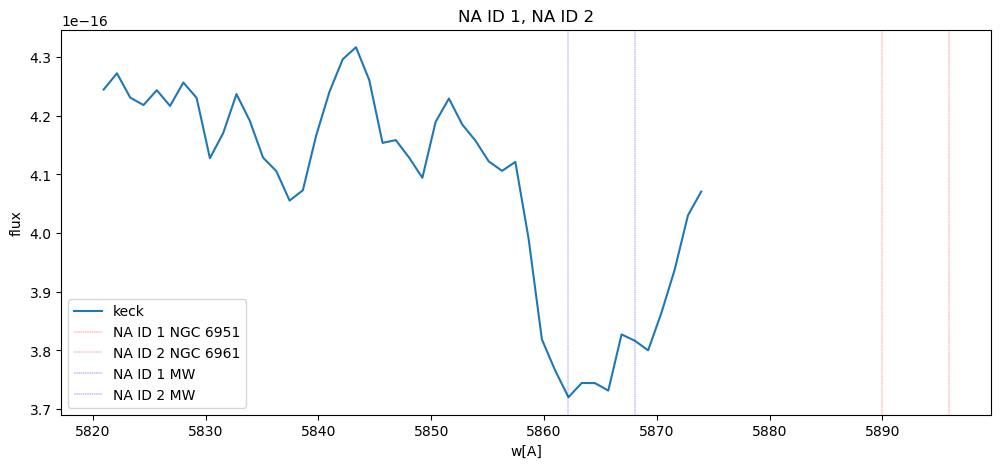

NA ID I NGC
5889.432121439559 5889.95
redshift=-0.000088
amplitude=4.043128320326565e-16
mean=5889.432121
std=4.806488

NA ID 2 NGC
5896.071114479423 5895.92
redshift=0.000026
amplitude=4.1744706272422577e-16
mean=5896.071114
std=4.860161

NA ID I MW
5862.04041464881 5862.10500124409
redshift=-0.000011
amplitude=4.122172040239538e-16
mean=5862.040415
std=4.444798

NA ID 2 MW
5868.195658851984 5868.046777805424
redshift=0.000025
amplitude=4.140691886261585e-16
mean=5868.195659
std=4.428875



In [318]:
# Step 3 - Normalise the spectrum by modelling the continuum
# NA ID 1, NA ID 2


fig, ax = plt.subplots(figsize=(12,5),nrows=1, ncols=1)
ax.plot(wav1[ind], dereddened_flux[ind], label = 'keck')

ax.axvline(NA_ID_1_NGC, color='red', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 1 NGC 6951')
ax.axvline(NA_ID_2_NGC, color='red', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 2 NGC 6961')
ax.axvline(NA_ID_1_MW, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 1 MW')
ax.axvline(NA_ID_2_MW, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 2 MW')
ax.legend()

#ax.plot(kwav,wflux, label = 'keck')
#ax.set_xlim(xmin=6540, xmax=6600)

plt.title("NA ID 1, NA ID 2")
plt.xlabel("w[A]")
ax.set_ylabel("flux")
plt.show()

region = 8


############################################################################
# get params for first NA ID NGC 6951 line
sub_region1 = SpectralRegion((NA_ID_1_NGC-region)*u.AA, (NA_ID_1_NGC+region)*u.AA)
sub_spectrum1 = extract_region(spectrum, sub_region1)
line_estimates1=estimate_line_parameters(sub_spectrum1, models.Gaussian1D())

print('NA ID I NGC')
print(line_estimates1.mean.value, NA_ID_1_NGC)
print('redshift=%.6f'%((line_estimates1.mean.value-NA_ID_1_NGC)/NA_ID_1_NGC))
print('amplitude=%s'%line_estimates1.amplitude.value)
print('mean=%.6f'%line_estimates1.mean.value)
print('std=%.6f'%line_estimates1.stddev.value)
print('')

##########################################################################
#get params for second line
sub_region2 = SpectralRegion((NA_ID_2_NGC-region)*u.AA, (NA_ID_2_NGC+region)*u.AA)
sub_spectrum2 = extract_region(spectrum, sub_region2)
line_estimates2=estimate_line_parameters(sub_spectrum2, models.Gaussian1D())

print('NA ID 2 NGC')
print(line_estimates2.mean.value, NA_ID_2_NGC)
print('redshift=%.6f'%((line_estimates2.mean.value-NA_ID_2_NGC)/NA_ID_2_NGC))
print('amplitude=%s'%line_estimates2.amplitude.value)
print('mean=%.6f'%line_estimates2.mean.value)
print('std=%.6f'%line_estimates2.stddev.value)
print('')

############################################################################
# get params for first NA ID MW line
sub_region3 = SpectralRegion((NA_ID_1_MW-region)*u.AA, (NA_ID_1_MW+region)*u.AA)
sub_spectrum3 = extract_region(spectrum, sub_region3)
line_estimates3=estimate_line_parameters(sub_spectrum3, models.Gaussian1D())

print('NA ID I MW')
print(line_estimates3.mean.value, NA_ID_1_MW)
print('redshift=%.6f'%((line_estimates3.mean.value-NA_ID_1_MW)/NA_ID_1_MW))
print('amplitude=%s'%line_estimates3.amplitude.value)
print('mean=%.6f'%line_estimates3.mean.value)
print('std=%.6f'%line_estimates3.stddev.value)
print('')

##########################################################################
#get params for second line
sub_region4 = SpectralRegion((NA_ID_2_MW-region)*u.AA, (NA_ID_2_MW+region)*u.AA)
sub_spectrum4 = extract_region(spectrum, sub_region4)
line_estimates4=estimate_line_parameters(sub_spectrum4, models.Gaussian1D())

print('NA ID 2 MW')
print(line_estimates4.mean.value, NA_ID_2_MW)
print('redshift=%.6f'%((line_estimates4.mean.value-NA_ID_2_MW)/NA_ID_2_MW))
print('amplitude=%s'%line_estimates4.amplitude.value)
print('mean=%.6f'%line_estimates4.mean.value)
print('std=%.6f'%line_estimates4.stddev.value)
print('')

In [319]:
line_estimates3.amplitude.value,line_estimates3.mean.value,line_estimates3.stddev.value,

(4.122172040239538e-16, 5862.04041464881, 4.444798450240478)

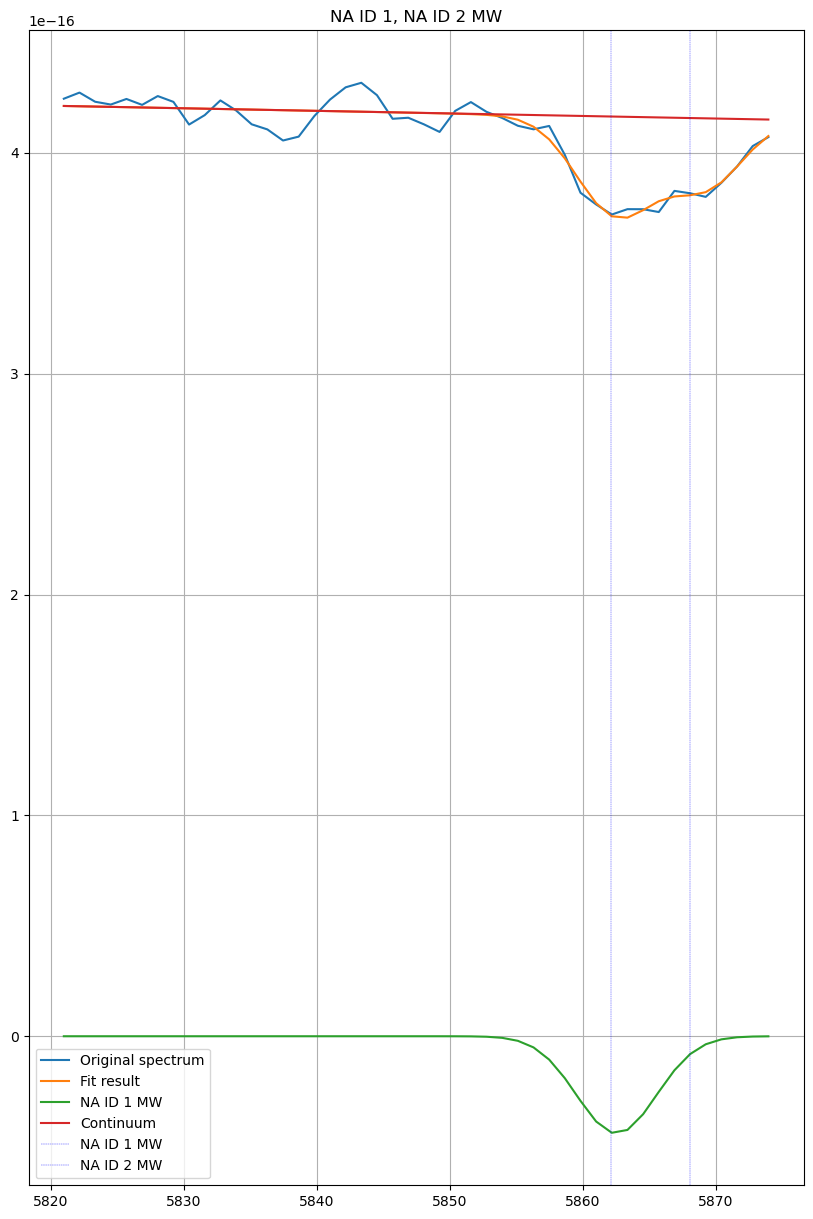

In [320]:
#### Fit the spectrum

g_init= models.Gaussian1D(amplitude=4.2368009513313117e-16, mean=5869.962793243836*u.AA, stddev=8.89549733051641*u.AA, fixed={'stddev': True,'mean': True})
g_NA_ID_1_NGC = models.Gaussian1D(amplitude=line_estimates1.amplitude.value, mean=line_estimates1.mean.value*u.AA, stddev=line_estimates1.stddev.value*u.AA)
g_NA_ID_2_NGC = models.Gaussian1D(amplitude=line_estimates2.amplitude.value, mean=line_estimates2.mean.value*u.AA, stddev=line_estimates2.stddev.value*u.AA)
g_NA_ID_1_MW = models.Gaussian1D(amplitude=line_estimates3.amplitude.value, mean=line_estimates3.mean.value*u.AA, stddev=line_estimates3.stddev.value*u.AA)
g_NA_ID_2_MW = models.Gaussian1D(amplitude=line_estimates4.amplitude.value, mean=line_estimates4.mean.value*u.AA, stddev=line_estimates4.stddev.value*u.AA)


g_cont = models.Linear1D(slope = 0, intercept = 0)
g_fit = fit_lines(sub_spectrum, g_init+g_NA_ID_1_MW+g_NA_ID_2_MW+g_NA_ID_1_NGC+g_NA_ID_2_NGC+models.Linear1D(slope=0, intercept=0), fitter=fitter)
y_fit = g_fit(sub_spectrum.spectral_axis)
#print(y_fit)
#print(sub_spectrum.spectral_axis)


# Plot the original spectrum and the fitted.
fig, ax = plt.subplots(figsize=(10,15),nrows=1, ncols=1)

plt.plot(sub_spectrum.spectral_axis, sub_spectrum.flux, label="Original spectrum")
plt.plot(sub_spectrum.spectral_axis, y_fit, label="Fit result")
#plt.plot(sub_spectrum.spectral_axis, g_fit[0](sub_spectrum.spectral_axis), label="NA ID 1 NGC")
#plt.plot(sub_spectrum.spectral_axis, g_fit[1](sub_spectrum.spectral_axis), label="NA ID 2 NGC")
plt.plot(sub_spectrum.spectral_axis, g_fit[1](sub_spectrum.spectral_axis), label="NA ID 1 MW")
#plt.plot(sub_spectrum.spectral_axis, g_fit[1](sub_spectrum.spectral_axis), label="NA ID 2 MW")
plt.plot(sub_spectrum.spectral_axis, g_fit[-1](sub_spectrum.spectral_axis), label="Continuum")

ax.axvline(NA_ID_1_MW, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 1 MW')
ax.axvline(NA_ID_2_MW, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 2 MW')
plt.title("NA ID 1, NA ID 2 MW")
plt.grid(True)
#plt.ylim(ymax=0.7e-15,ymin=-0.3e-15)
plt.legend()
plt.show()

In [101]:
# Step 4 - Fit Gaussian profile to the Na I D absorption profile

In [ ]:
# Step 5 - Measure EW and uncertainty

In [ ]:
# Step 6 - Make pretty plot of this :)

In [ ]:
plt.plot(sub_spectrum.spectral_axis, sub_spectrum.flux) 

In [ ]:
wav1[ind].min()
wav1[ind].max()

In [53]:
fitter.fit_info['message']

'Number of calls to function has reached maxfev = 100.'

Parameter('amplitude', value=4.1744706272422577e-16)
erg / (Angstrom cm2 s)
[3.87184345e-16 3.79133541e-16 3.67309081e-16 3.50719408e-16
 3.28518259e-16 3.00233499e-16 2.66049730e-16 2.26903540e-16
 1.84769807e-16 1.42493248e-16 1.03554772e-16 7.16245194e-17
 5.00005227e-17 4.10495631e-17 4.57808856e-17 6.36589190e-17
 9.27030465e-17]


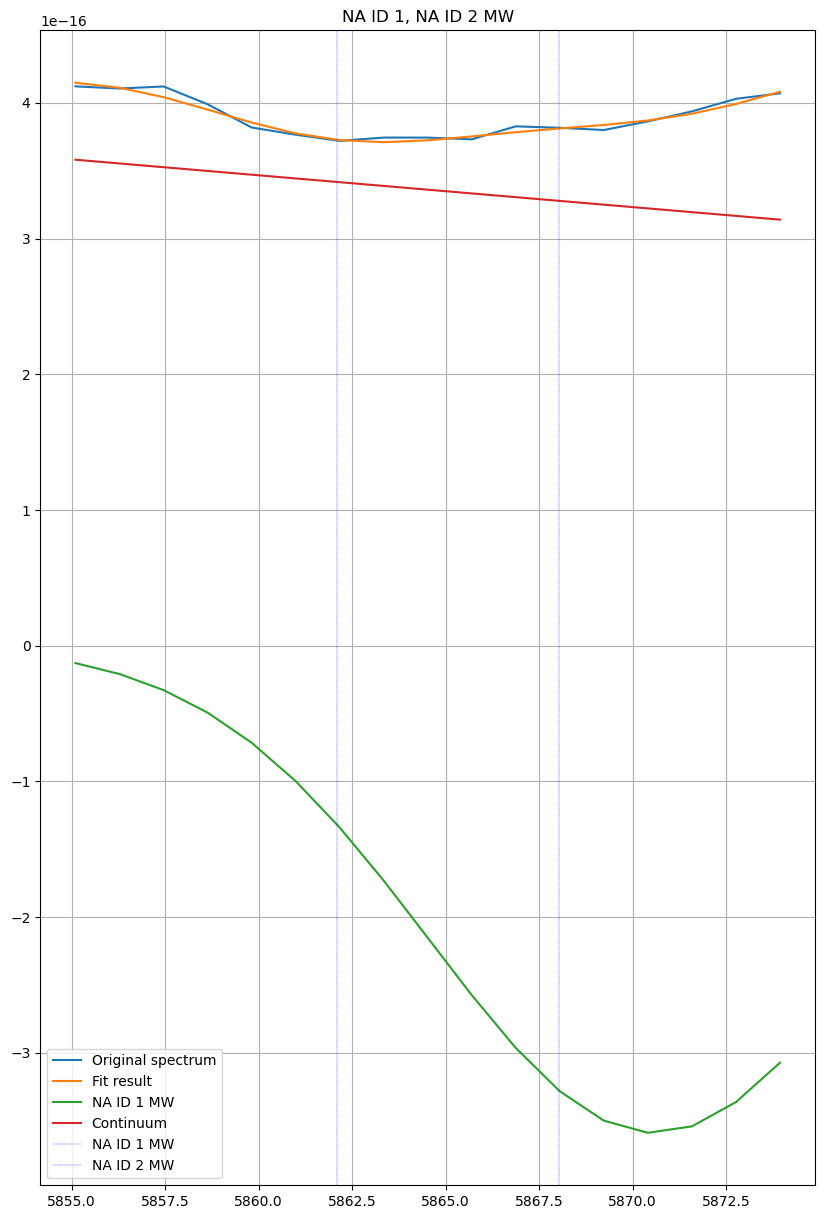

Text(0, 0.5, 'Flux')

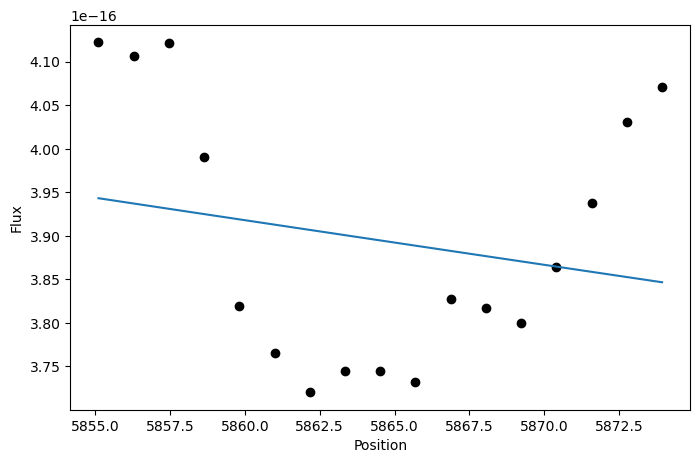